# Team Data_perito DatafestAfrica ML Hackathon Solution
## Predicting who is likely to complete the E-process application of a Financial Industry

In [ ]:
#import all packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import shap

from sklearn.metrics import accuracy_score, roc_auc_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
warnings.filterwarnings('ignore')

%matplotlib inline
warnings.filterwarnings('ignore')

In [ ]:
#loading data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Data Analysis

### Introduction
> This exploration is done on the train and test data provided for the competition. There are 21 features and 20 features in train and test respectively.

In [ ]:
#top 5 rows
train.head()

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,amount_requested,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,550,36200,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1
1,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,1100,53850,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0
2,8492423,21,weekly,0,2303,0,5,8,2,7,...,600,74850,0.677109,0.758765,0.495609,0.664762,0.592556,0.492556,6,1
3,7948313,26,bi-weekly,0,2795,0,4,4,1,6,...,800,50800,0.738055,0.873204,0.666437,0.700392,0.584130,0.684130,14,1
4,4297036,43,bi-weekly,0,5000,0,2,1,1,2,...,1100,69100,0.798303,0.841747,0.401971,0.568787,0.525905,0.725905,5,1


In [ ]:
print(f'The shape of the train data is {train.shape}')
print(f'The shape of the test data is {test.shape}')

The shape of the train data is (12516, 21)
The shape of the test data is (5392, 20)


In [ ]:
#List of columns in the train data
train.columns

Index(['Entry_id', 'age', 'pay_schedule', 'home_owner', 'income',
       'months_employed', 'years_employed', 'current_address_year',
       'personal_account_m', 'personal_account_y', 'has_debt',
       'amount_requested', 'risk_score', 'risk_score_2', 'risk_score_3',
       'risk_score_4', 'risk_score_5', 'ext_quality_score',
       'ext_quality_score_2', 'inquiries_last_month', 'e_signed'],
      dtype='object')

In [ ]:
#List of columns in the test data
test.columns

Index(['Entry_id', 'age', 'pay_schedule', 'home_owner', 'income',
       'months_employed', 'years_employed', 'current_address_year',
       'personal_account_m', 'personal_account_y', 'has_debt',
       'amount_requested', 'risk_score', 'risk_score_2', 'risk_score_3',
       'risk_score_4', 'risk_score_5', 'ext_quality_score',
       'ext_quality_score_2', 'inquiries_last_month'],
      dtype='object')

The train contain 12516 records, 21 columns while the test contain 5392 records and 20 columns. The difference of the train and test in features is the target column `e_signed`.

In [ ]:
#Basic information of the train data
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12516 entries, 0 to 12515
Data columns (total 21 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entry_id              12516 non-null  int64  
 1   age                   12516 non-null  int64  
 2   pay_schedule          12516 non-null  object 
 3   home_owner            12516 non-null  int64  
 4   income                12516 non-null  int64  
 5   months_employed       12516 non-null  int64  
 6   years_employed        12516 non-null  int64  
 7   current_address_year  12516 non-null  int64  
 8   personal_account_m    12516 non-null  int64  
 9   personal_account_y    12516 non-null  int64  
 10  has_debt              12516 non-null  int64  
 11  amount_requested      12516 non-null  int64  
 12  risk_score            12516 non-null  int64  
 13  risk_score_2          12516 non-null  float64
 14  risk_score_3          12516 non-null  float64
 15  risk_score_4       

In [ ]:
#Basic information of the test data
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5392 entries, 0 to 5391
Data columns (total 20 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Entry_id              5392 non-null   int64  
 1   age                   5392 non-null   int64  
 2   pay_schedule          5392 non-null   object 
 3   home_owner            5392 non-null   int64  
 4   income                5392 non-null   int64  
 5   months_employed       5392 non-null   int64  
 6   years_employed        5392 non-null   int64  
 7   current_address_year  5392 non-null   int64  
 8   personal_account_m    5392 non-null   int64  
 9   personal_account_y    5392 non-null   int64  
 10  has_debt              5392 non-null   int64  
 11  amount_requested      5392 non-null   int64  
 12  risk_score            5392 non-null   int64  
 13  risk_score_2          5392 non-null   float64
 14  risk_score_3          5392 non-null   float64
 15  risk_score_4         

The train and test is made up of float, int and object dtypes. Some of the features have been preprocessed to numerical e.g `home_owner`, `months_employed`, `years_employed` which could have been categorical.

The dataset(train and test) contain no missing values.

In [ ]:
# checking for duplicates in both train and test data
print(train.duplicated().sum())
print(test.duplicated().sum())

0
0


Both the train and test contain no duplicate.

#### Age

In [ ]:
#distribution plot for the age

In [ ]:
#a function to plot histogram
def histogram(name):
    fig, ax = plt.subplots(ncols=2, figsize = [10,5])
    ax[0].hist(train[name])
    ax[1].hist(test[name])
    plt.xlabel(name)
    ax[0].title.set_text(name+'_Train')
    ax[1].title.set_text(name+'_Test');

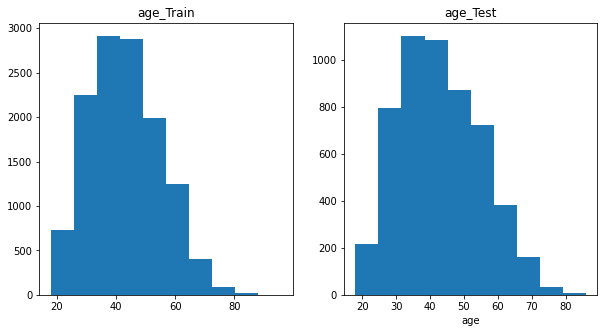

In [ ]:
histogram('age')

The distribution of the age follows a normal distribution. and 90% of the age of the record is between 30 - 60 years. And the distribution plotted shows no outliers.

#### Pay_schedule

In [ ]:
#a function to plot count of categories
def countplot(name):
    
    #to set order of categories
    train_order = train[name].value_counts().keys()
    test_order = test[name].value_counts().keys()
    
    fig, ax = plt.subplots(ncols=2, figsize = [10,5])
    sns.countplot(train[name], ax=ax[0], color='blue', order=train_order)
    sns.countplot(test[name], ax=ax[1], color='blue', order=test_order)
    
    ax[0].title.set_text(name+'_Train')
    ax[1].title.set_text(name+'_Test');

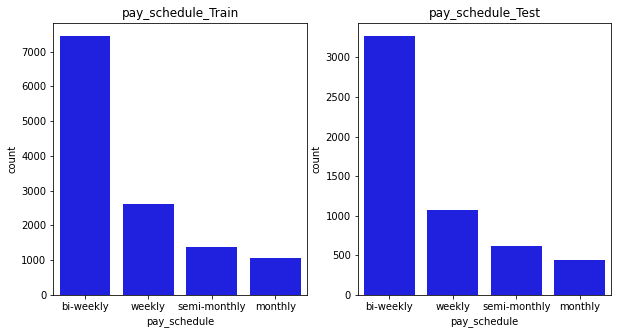

In [ ]:
countplot('pay_schedule')

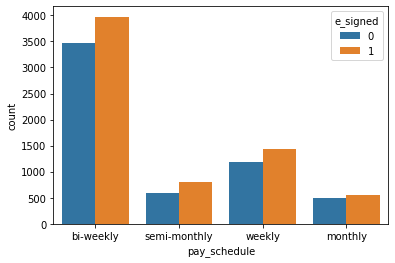

In [ ]:
sns.countplot(train.pay_schedule, hue=train.e_signed);

In both cases of our data, the bi-weekly pay schedule is the most preferred way of payment followed by weeky and lastly monthly. The chart also shows that there are 4 categories of pay schedule; Weekly, Bi-weekly, Semi-monthly and Monthly.

The payment method using ratio of each categories has no much impact on the approval.

#### Home Owner

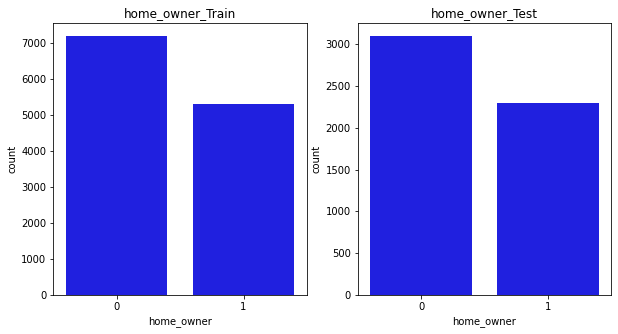

In [ ]:
countplot('home_owner')

In [ ]:
train.home_owner.value_counts(normalize=True)

0    0.574944
1    0.425056
Name: home_owner, dtype: float64

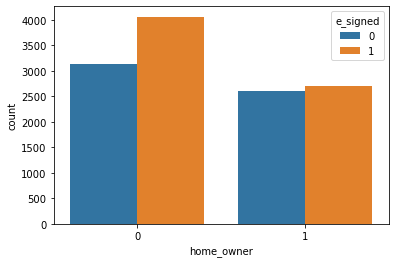

In [ ]:
sns.countplot(train.home_owner, hue=train.e_signed);

Assuming having a home is 1 and not is 0, it shows that in the dataset does without homes are a little bit more than those who have. 

Almost all home owner gets equal chance of getting approved or rejected. 

### Income

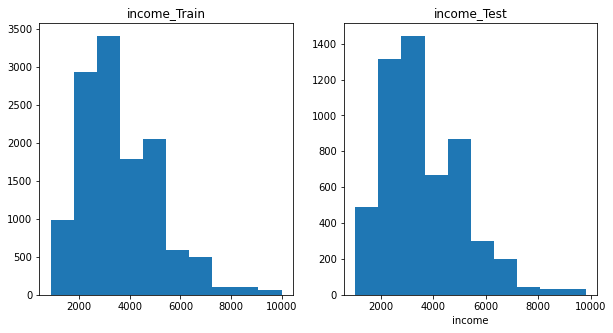

In [ ]:
histogram('income')

The income distribution is right skewed, it also show as spike of customer earning within 2000 to 3000 borrowing more. 
A log transformation of this may improve modelo performance and further analysis.

#### Month Employed

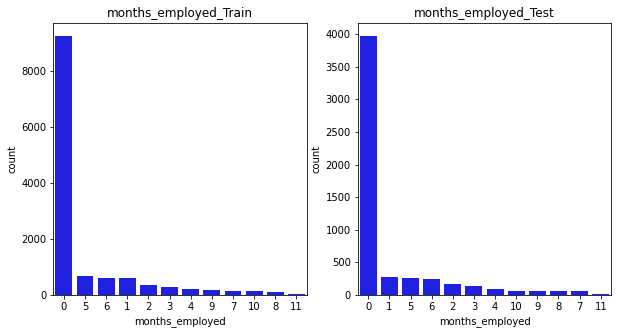

In [ ]:
countplot('months_employed')

Something seems not right, the data shows a behaviour of customer having more to borrow in the 0 month which can be December or January. This period is a festive period
To boost model performance this feature can be dummified or used in feature generation.

#### Year Employed

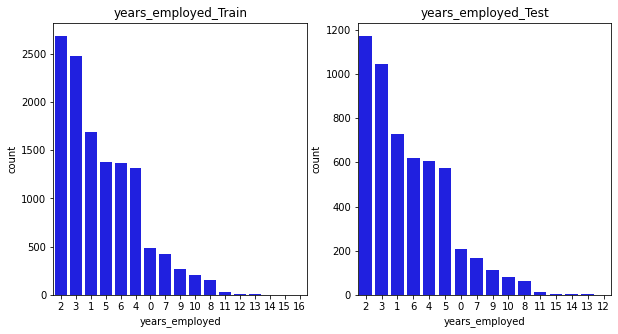

In [ ]:
countplot('years_employed')

Majority of the those that borrow have less than 7 years of employment. and one-hot will be a bad idea for the feature, the train has data with higher year of employment than the test.

#### Current Address Year

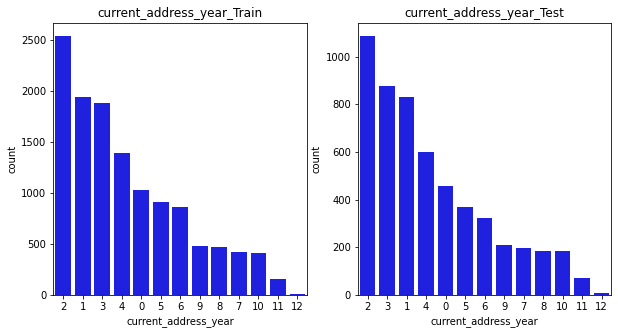

In [ ]:
countplot('current_address_year')

#### Has Debt

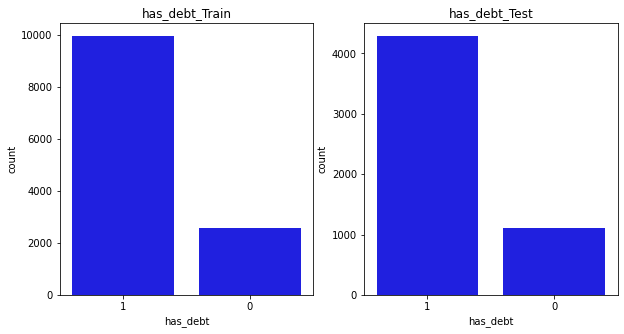

In [ ]:
countplot('has_debt')

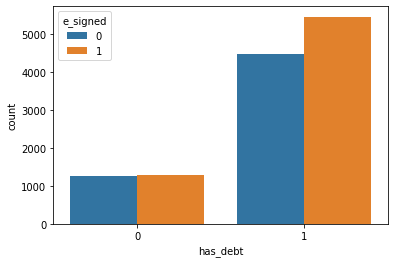

In [ ]:
sns.countplot(train.has_debt, hue = train.e_signed);

This shows that majority has debt, if 1 represent Yes in the encoded data. And there is a strong correlation between the e-signed and the 0 has_debt.
Shows that having debt might be a good consideration in approving loan.

#### Amount Request

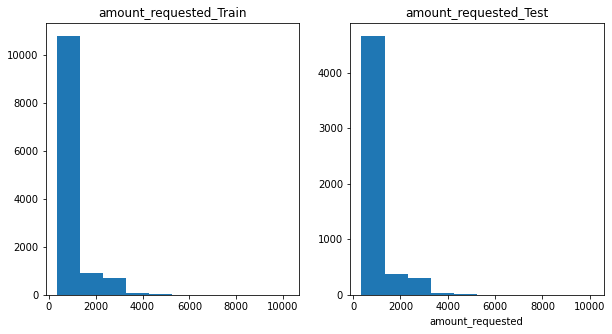

In [ ]:
histogram('amount_requested')

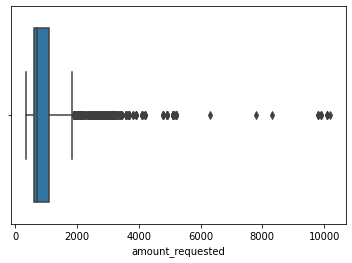

In [ ]:
sns.boxplot(train.amount_requested)

The amount requested can be has high as 10000, which can be outlier, and it is left skewed. Log transformation can cause a change.

#### Risk Score

In [ ]:
train[['risk_score', 'risk_score_2', 'risk_score_3',
       'risk_score_4', 'risk_score_5']].head()

,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5
0,36200,0.737398,0.903517,0.487712,0.515977
1,53850,0.617361,0.857560,0.613487,0.665523
2,74850,0.677109,0.758765,0.495609,0.664762
3,50800,0.738055,0.873204,0.666437,0.700392
4,69100,0.798303,0.841747,0.401971,0.568787


The risk score value seems odd compared to others which could have been a mistake. It will be divided by 100000 to bring it to others level

In [ ]:
train.risk_score = train.risk_score/100000
test.risk_score = test.risk_score/100000

Getting the average of the risk_scores might be a good one and for further exploration

In [ ]:
train['risk_average'] = (train.risk_score + train.risk_score_2 + train.risk_score_3 + train.risk_score_4 + train.risk_score_5)/5

test['risk_average'] = (test.risk_score + test.risk_score_2 + test.risk_score_3 + test.risk_score_4 + test.risk_score_5)/5

### Checking the average risk score of the loan approved compared to the others

In [ ]:
train.head()

,Entry_id,age,pay_schedule,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,...,risk_score,risk_score_2,risk_score_3,risk_score_4,risk_score_5,ext_quality_score,ext_quality_score_2,inquiries_last_month,e_signed,risk_average
0,7629673,40,bi-weekly,1,3135,0,3,3,6,2,...,0.3620,0.737398,0.903517,0.487712,0.515977,0.580918,0.380918,10,1,0.601321
1,5335819,33,semi-monthly,0,3590,0,5,2,2,8,...,0.5385,0.617361,0.857560,0.613487,0.665523,0.744634,0.744634,12,0,0.658486
2,8492423,21,weekly,0,2303,0,5,8,2,7,...,0.7485,0.677109,0.758765,0.495609,0.664762,0.592556,0.492556,6,1,0.668949
3,7948313,26,bi-weekly,0,2795,0,4,4,1,6,...,0.5080,0.738055,0.873204,0.666437,0.700392,0.584130,0.684130,14,1,0.697218
4,4297036,43,bi-weekly,0,5000,0,2,1,1,2,...,0.6910,0.798303,0.841747,0.401971,0.568787,0.525905,0.725905,5,1,0.660362


In [ ]:
train.groupby('e_signed').mean()['risk_average']

e_signed
0    0.693592
1    0.698511
Name: risk_average, dtype: float64

There is no significant different between the average of the risk of both groups.

#### Ext Quality Score

Finding the mean of the ext_quality_score

In [ ]:
train['ext_quality_average'] = (train['ext_quality_score'] + train['ext_quality_score_2'])/2

test['ext_quality_average'] = (test['ext_quality_score'] + test['ext_quality_score_2'])/2

In [ ]:
train.groupby('e_signed').mean()['ext_quality_average']

e_signed
0    0.625758
1    0.618673
Name: ext_quality_average, dtype: float64

There is also no significant difference between the approved and rejected ext_quality average.

#### Inquiries Last Month

In [ ]:
train.inquiries_last_month.value_counts()

6     2065
5     1937
4     1683
3     1283
7     1230
8      918
2      880
9      610
10     489
11     352
12     234
13     186
14     132
15     105
16      81
17      58
18      52
19      49
20      31
21      31
22      23
24      16
23      14
26      14
27      12
25       9
28       9
1        6
29       4
30       3
Name: inquiries_last_month, dtype: int64

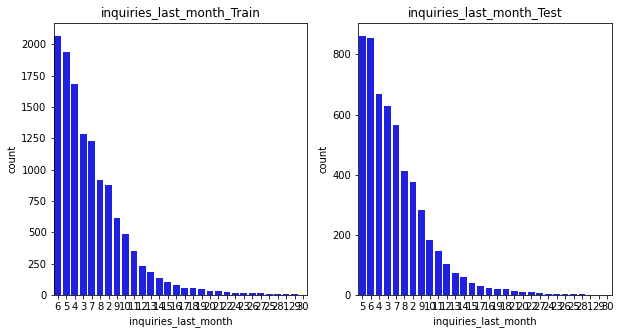

In [ ]:
countplot('inquiries_last_month')

In [ ]:
train.groupby('e_signed').mean()['inquiries_last_month']

e_signed
0    6.622609
1    6.384866
Name: inquiries_last_month, dtype: float64

 For both cases the average number on inquiries in the previous month is 6 to 7 times.

## Data Preprocessing

In [ ]:
train['sum_risk_score'] = (train['risk_score'] + train['risk_score_2'] + train['risk_score_3'] + train['risk_score_4'] + train['risk_score_5']).abs()
# train['mean_risk_score'] = train['sum_risk_score']/5

train['sum_ext_quality_score'] = (train['ext_quality_score'] + train['ext_quality_score_2']).abs()
# train['mean_ext_quality_score'] = train[['ext_quality_score', 'ext_quality_score_2']].mean(axis = 1)
train['diff_ext_quality_score'] = (train['ext_quality_score'] - train['ext_quality_score_2']).abs()

In [ ]:
test['sum_risk_score'] = (test['risk_score'] + test['risk_score_2'] + test['risk_score_3'] + test['risk_score_4'] + test['risk_score_5']).abs()
# test['mean_risk_score'] = test['sum_risk_score'] / 5

test['diff_ext_quality_score'] = (test['ext_quality_score'] - test['ext_quality_score_2']).abs()
test['sum_ext_quality_score'] = (test['ext_quality_score'] + test['ext_quality_score_2']).abs()
# test['mean_ext_quality_score'] = test['sum_ext_quality_score'] / 2

In [ ]:
train['ext_quality_score_std'] = train[['ext_quality_score', 'ext_quality_score_2']].std(axis = 1)
test['ext_quality_score_std'] = test[['ext_quality_score', 'ext_quality_score_2']].std(axis = 1)

In [ ]:
train['income_age'] = train['income'] / train['age']
train['ammount_age'] = train['amount_requested'] / train['age']
train['amount_income'] = train['amount_requested']/ train['income']
train['personal_account_m_y'] = train['personal_account_y'] - train['personal_account_m']
train['work_year'] = train['income'] / train['years_employed']

In [ ]:
test['income_age'] = test['income'] / test['age']
test['ammount_age'] = test['amount_requested'] / test['age']
test['amount_income'] = test['amount_requested']/ test['income']
test['personal_account_m_y'] = test['personal_account_y'] - test['personal_account_m']
test['work_year'] = test['income'] / test['years_employed']

In [ ]:
test = test.drop('Entry_id', axis=1)
train = train.drop('Entry_id', axis=1)

In [ ]:
train = train.join(pd.get_dummies(train.pay_schedule))
test = test.join(pd.get_dummies(test.pay_schedule))

In [ ]:
train.isnull().sum()

age                       0
pay_schedule              0
home_owner                0
income                    0
months_employed           0
years_employed            0
current_address_year      0
personal_account_m        0
personal_account_y        0
has_debt                  0
amount_requested          0
risk_score                0
risk_score_2              0
risk_score_3              0
risk_score_4              0
risk_score_5              0
ext_quality_score         0
ext_quality_score_2       0
inquiries_last_month      0
e_signed                  0
risk_average              0
ext_quality_average       0
sum_risk_score            0
sum_ext_quality_score     0
diff_ext_quality_score    0
ext_quality_score_std     0
income_age                0
ammount_age               0
amount_income             0
personal_account_m_y      0
work_year                 0
bi-weekly                 0
monthly                   0
semi-monthly              0
weekly                    0
dtype: int64

In [ ]:
train.shape

(12516, 35)

In [ ]:
test.shape

(5392, 34)

In [ ]:
test.columns

Index(['age', 'pay_schedule', 'home_owner', 'income', 'months_employed',
       'years_employed', 'current_address_year', 'personal_account_m',
       'personal_account_y', 'has_debt', 'amount_requested', 'risk_score',
       'risk_score_2', 'risk_score_3', 'risk_score_4', 'risk_score_5',
       'ext_quality_score', 'ext_quality_score_2', 'inquiries_last_month',
       'risk_average', 'ext_quality_average', 'sum_risk_score',
       'diff_ext_quality_score', 'sum_ext_quality_score',
       'ext_quality_score_std', 'income_age', 'ammount_age', 'amount_income',
       'personal_account_m_y', 'work_year', 'bi-weekly', 'monthly',
       'semi-monthly', 'weekly'],
      dtype='object')

In [ ]:
to_drop = ['risk_score',
       'risk_score_2', 'risk_score_3', 'risk_score_4', 'risk_score_5',
       'ext_quality_score', 'ext_quality_score_2', 'pay_schedule']

In [ ]:
test = test.drop(to_drop, axis = 1)
train = train.drop(to_drop, axis = 1)

In [ ]:
print(train.shape)
print(test.shape)

(12516, 27)
(5392, 26)


In [ ]:
train.head()

,Entry_id,age,home_owner,income,months_employed,years_employed,current_address_year,personal_account_m,personal_account_y,has_debt,...,ext_quality_score_std,income_age,ammount_age,amount_income,personal_account_m_y,work_year,bi-weekly,monthly,semi-monthly,weekly
0,7629673,40,1,3135,0,3,3,6,2,1,...,0.141421,78.375000,13.750000,0.175439,-4,1045.00,1,0,0,0
1,5335819,33,0,3590,0,5,2,2,8,1,...,0.000000,108.787879,33.333333,0.306407,6,718.00,0,0,1,0
2,8492423,21,0,2303,0,5,8,2,7,1,...,0.070711,109.666667,28.571429,0.260530,5,460.60,0,0,0,1
3,7948313,26,0,2795,0,4,4,1,6,1,...,0.070711,107.500000,30.769231,0.286225,5,698.75,1,0,0,0
4,4297036,43,0,5000,0,2,1,1,2,1,...,0.141421,116.279070,25.581395,0.220000,1,2500.00,1,0,0,0


## Modelling


In [ ]:
x = train.drop('e_signed', axis = 1)
y = train['e_signed']

#### Catboost

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2) 

In [ ]:
import catboost as ctb
ct_mod = ctb.CatBoostClassifier(n_estimators=5000, learning_rate=0.01)
ct_mod.fit(x_train, y_train)

In [ ]:
def evaluate(model):
    y_pred = model.predict(x_test)
    print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}%\n")
    print(f"The F1 score of the {type(model).__name__} is {round(f1_score(y_test, y_pred, average='macro') * 100)}%\n")
    print(f'The roc auc score is {roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])}')

#### lightgbm

In [ ]:
# from lightgbm import LGBMClassifier
lb = LGBMClassifier(learning_rate= 0.01, n_estimators=1000)
lb.fit(x_train, y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=1000)

In [ ]:
evaluate(lb)

The accuracy score of the LGBMClassifier is 62%

The F1 score of the LGBMClassifier is 62%

The roc auc score is 0.6758070560797828


In [ ]:
evaluate(ct_mod)

The accuracy score of the CatBoostClassifier is 62%

The F1 score of the CatBoostClassifier is 61%

The roc auc score is 0.6725093419163898


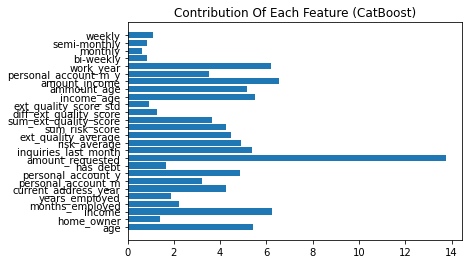

In [ ]:
plt.barh(x.columns, ct_mod.feature_importances_)
plt.title("Contribution Of Each Feature (CatBoost)")
plt.show()

In [ ]:
pred = ct_mod.predict_proba(test)[:,1]
pred.sum()

2907.6405842650156

In [ ]:
entry = pd.read_csv('test.csv')['Entry_id']
sub = pd.DataFrame({'Entry_id':entry, 'e_signed':pred})
sub.to_csv('ola2.csv', index = False)

#### KFOLD

In [ ]:
X = x.copy()

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def evaluate(model, x_test, y_test):
    y_pred = model.predict(x_test)
    
    print(f"The accuracy score of the {type(model).__name__} is {round(accuracy_score(y_test, y_pred) * 100)}")
    print(f"The F1 score of the {type(model).__name__} is {round(f1_score(y_test, y_pred, average='macro') * 100)}")
    print('AUC', roc_auc_score(y_test, model.predict_proba(x_test)[:, 1]))

In [ ]:
kf = KFold(n_splits=5,random_state=43,shuffle=True)
# cat_scores = []
# cat_proba = []
cat_pred = np.zeros(len(test))
thresh = 0.4
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(n_estimators= 5000, verbose =1000,random_state=7)
    cat.fit(X_train,y_train)
    evaluate(cat, X_test, y_test)
    
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
Learning rate set to 0.006298
0:	learn: 0.6927044	total: 8.14ms	remaining: 40.7s
1000:	learn: 0.6082683	total: 7.1s	remaining: 28.4s
2000:	learn: 0.5688986	total: 14.2s	remaining: 21.3s
3000:	learn: 0.5338588	total: 21.3s	remaining: 14.2s
4000:	learn: 0.5044254	total: 28.4s	remaining: 7.1s
4999:	learn: 0.4783467	total: 36.2s	remaining: 0us
The accuracy score of the CatBoostClassifier is 62
The F1 score of the CatBoostClassifier is 62
AUC 0.6780534326632843
================================Fold1====================================
Learning rate set to 0.006298
0:	learn: 0.6927757	total: 7.81ms	remaining: 39s
1000:	learn: 0.6081128	total: 7.13s	remaining: 28.5s
2000:	learn: 0.5673833	total: 14.3s	remaining: 21.5s
3000:	learn: 0.5315610	total: 22.8s	remaining: 15.2s
4000:	learn: 0.5014271	total: 30s	remaining: 7.49s
4999:	learn: 0.4749392	total: 37.4s	remaining: 0us
The accuracy score of the CatBoostClassifier is 61


#### Stratified KFOLD(Best Performance)

In [ ]:
kf = StratifiedKFold(n_splits=5,random_state=43,shuffle=True)
# cat_scores = []
# cat_proba = []
cat_pred = np.zeros(len(test))
# thresh = 0.4
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(n_estimators= 5000, verbose =1000,random_state=7)
    cat.fit(X_train,y_train)
    evaluate(cat, X_test, y_test)
    
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
Learning rate set to 0.006298
0:	learn: 0.6927681	total: 7.07ms	remaining: 35.4s
1000:	learn: 0.6077772	total: 7.28s	remaining: 29.1s
2000:	learn: 0.5666086	total: 17.3s	remaining: 25.9s
3000:	learn: 0.5309748	total: 29.1s	remaining: 19.4s
4000:	learn: 0.5011911	total: 36.5s	remaining: 9.1s
4999:	learn: 0.4748111	total: 43.7s	remaining: 0us
The accuracy score of the CatBoostClassifier is 62
The F1 score of the CatBoostClassifier is 61
AUC 0.6698432984394066
================================Fold1====================================
Learning rate set to 0.006298
0:	learn: 0.6926897	total: 6.97ms	remaining: 34.8s
1000:	learn: 0.6109130	total: 7.19s	remaining: 28.7s
2000:	learn: 0.5716456	total: 14.4s	remaining: 21.5s
3000:	learn: 0.5369241	total: 21.5s	remaining: 14.4s
4000:	learn: 0.5074715	total: 28.8s	remaining: 7.19s
4999:	learn: 0.4819454	total: 36s	remaining: 0us
The accuracy score of the CatBoostClassifier is 

In [ ]:
kf = StratifiedKFold(n_splits=10,random_state=43,shuffle=True)
# cat_scores = []
# cat_proba = []
cat_pred = np.zeros(len(test))
# thresh = 0.4
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    cat = CatBoostClassifier(n_estimators= 5000, verbose =3000,random_state=7)
    cat.fit(X_train,y_train)
    evaluate(cat, X_test, y_test)
    
    cat_pred += cat.predict_proba(test)[:,1]

================================Fold0====================================
Learning rate set to 0.006623
0:	learn: 0.6926692	total: 7.5ms	remaining: 37.5s
3000:	learn: 0.5365199	total: 22.4s	remaining: 14.9s
4999:	learn: 0.4827864	total: 37.5s	remaining: 0us
The accuracy score of the CatBoostClassifier is 62
The F1 score of the CatBoostClassifier is 62
AUC 0.6716305953374864
================================Fold1====================================
Learning rate set to 0.006623
0:	learn: 0.6926769	total: 8.16ms	remaining: 40.8s
3000:	learn: 0.5360944	total: 22.5s	remaining: 15s
4999:	learn: 0.4829537	total: 37.4s	remaining: 0us
The accuracy score of the CatBoostClassifier is 63
The F1 score of the CatBoostClassifier is 62
AUC 0.681122599704579
================================Fold2====================================
Learning rate set to 0.006623
0:	learn: 0.6926825	total: 12.3ms	remaining: 1m 1s
3000:	learn: 0.5383374	total: 22.2s	remaining: 14.8s
4999:	learn: 0.4850806	total: 39.8s	rema

In [ ]:
cat_pred = cat_pred/5

In [ ]:
cat_pred = cat_pred/10

In [ ]:
cat_sub = pd.DataFrame({'Entry_id':entry, 'e_signed':cat_pred})
cat_sub.to_csv('cat_pred_strat10.csv', index = False)

#### LightGBM

In [ ]:
kf = KFold(n_splits=5,random_state=43,shuffle=True)
# lgb_scores = []
# lgb_proba = []
lgb_pred = np.zeros(len(test))
thresh = 0.4
for fold,(tr_in,te_in) in enumerate(kf.split(X,y)):
    print("================================Fold{fold}====================================".format(fold=fold))
    X_train,X_test = X.iloc[tr_in],X.iloc[te_in]
    y_train,y_test = y.iloc[tr_in],y.iloc[te_in]

    lgb = LGBMClassifier(n_estimators=5000, learning_rate=0.01, subsample=0.6,
                           colsample_bytree=0.5, max_depth=4,random_state = 7,
                        min_child_weight = 12,silent = True, num_leaves = 22)
    lgb.fit(X_train,y_train)
    evaluate(lgb, X_test, y_test)
    
    lgb_pred += lgb.predict_proba(test)[:,1]

================================Fold0====================================
The accuracy score of the LGBMClassifier is 61
The F1 score of the LGBMClassifier is 60
AUC 0.666799820178537
================================Fold1====================================
The accuracy score of the LGBMClassifier is 61
The F1 score of the LGBMClassifier is 61
AUC 0.6644164580323773
================================Fold2====================================
The accuracy score of the LGBMClassifier is 61
The F1 score of the LGBMClassifier is 61
AUC 0.6679176845636723
================================Fold3====================================
The accuracy score of the LGBMClassifier is 64
The F1 score of the LGBMClassifier is 63
AUC 0.6939335735325396
================================Fold4====================================
The accuracy score of the LGBMClassifier is 63
The F1 score of the LGBMClassifier is 63
AUC 0.6877125550236778


In [ ]:
lgb_pred = lgb_pred/5

lgb_sub = pd.DataFrame({'Entry_id':entry, 'e_signed':lgb_pred})

lgb_sub.to_csv('lgb_pred.csv', index = False)

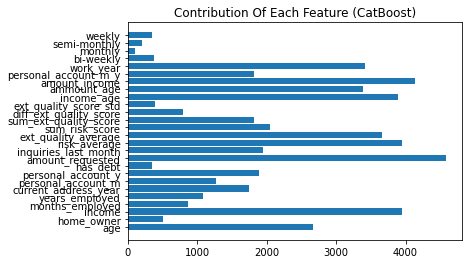

In [ ]:
plt.barh(x.columns, lgb.feature_importances_)
plt.title("Contribution Of Each Feature (CatBoost)")
plt.show()

#### Stacking

In [ ]:
blend=(cat_pred + lgb_pred)/2
blend

array([0.27812895, 0.54607245, 0.33220958, ..., 0.34328958, 0.28487439,
       0.3239164 ])

In [ ]:
cat_pred

array([0.08486574, 0.16837774, 0.10369425, ..., 0.11567801, 0.08582965,
       0.11106159])

In [ ]:
lgb_pred

array([0.47139216, 0.92376716, 0.56072492, ..., 0.57090114, 0.48391913,
       0.5367712 ])

In [ ]:
blend_sub = pd.DataFrame({'Entry_id':entry, 'e_signed':blend})

blend_sub.to_csv('blend.csv', index = False)



---



---

